## Credit Card Fraud 

Cody Allen, Chase Walsh, Pedro Storch

In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from geopy.distance import geodesic
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
import warnings
warnings.filterwarnings('ignore')

In [91]:

df = pd.read_csv("fraud_data.csv")

In [92]:
df

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
0,04-01-2019 00:58,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a3806e984cec6ac0096d8184c64ad3a1,65.654142,-164.722603,1
1,04-01-2019 15:06,Predovic Inc,shopping_net,966.11,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a59185fe1b9ccf21323f581d7477573f,65.468863,-165.473127,1
2,04-01-2019 22:37,Wisozk and Sons,misc_pos,49.61,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,86ba3a888b42cd3925881fa34177b4e0,65.347667,-165.914542,1
3,04-01-2019 23:06,Murray-Smitham,grocery_pos,295.26,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,3a068fe1d856f0ecedbed33e4b5f4496,64.445035,-166.080207,1
4,04-01-2019 23:59,Friesen Lt,health_fitness,18.17,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,891cdd1191028759dc20dc224347a0ff,65.447094,-165.446843,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14441,22-01-2019 00:37,Hudson-Grady,shopping_pos,122.00,Athena,OR,45.8289,-118.4971,1302,Dealer,18-10-1976,699a4c06b22711bf3e0d8ef91232d356,46.442439,-118.524214,0
14442,22-01-2019 00:41,"""Nienow, Ankunding and Collie""",misc_pos,9.07,Gardiner,OR,43.7857,-124.1437,260,"""Engineer, maintenance""",01-09-1956,080d620d24815c7d6c637cf0b71dde8e,42.901265,-124.995317,0
14443,22-01-2019 00:42,Pacocha-O'Reilly,grocery_pos,104.84,Alva,WY,44.6873,-104.4414,110,"""Administrator, local government""",16-05-1973,3c346c8cd627c5fe3ed57430db2e9ae7,45.538062,-104.542117,0
14444,22-01-2019 00:48,"""Bins, Balistreri and Beatty""",shopping_pos,268.16,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,e66ffcc95ba7fc490486242af1205d04,64.081462,-165.898698,0


In [93]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14446 entries, 0 to 14445
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trans_date_trans_time  14446 non-null  object 
 1   merchant               14446 non-null  object 
 2   category               14446 non-null  object 
 3   amt                    14446 non-null  float64
 4   city                   14446 non-null  object 
 5   state                  14446 non-null  object 
 6   lat                    14446 non-null  float64
 7   long                   14446 non-null  float64
 8   city_pop               14446 non-null  int64  
 9   job                    14446 non-null  object 
 10  dob                    14446 non-null  object 
 11  trans_num              14446 non-null  object 
 12  merch_lat              14446 non-null  float64
 13  merch_long             14446 non-null  float64
 14  is_fraud               14446 non-null  object 
dtypes:

In [94]:
#Value counts show that the data is imbalanced. Which is what would be expected for fraudulent activity.
df['is_fraud'].value_counts()

is_fraud
0                         12600
1                          1844
1"2020-12-24 16:56:24"        1
0"2019-01-01 00:00:44"        1
Name: count, dtype: int64

In [95]:
#Dropping the two observations that are not a 0 or 1 but also have a timestamp.
df = df[df['is_fraud'].isin(['1', '0'])]


In [96]:
#Deleting trans_num as it provides no information in the prediction of fraud.
del df['trans_num']

#### Feature Engineering

In [97]:
#Creating an age category
df['dob'][0]
df['age'] = (pd.to_datetime(df['trans_date_trans_time'], format="%d-%m-%Y %H:%M") - 
             pd.to_datetime(df['dob'], format="%d-%m-%Y")).dt.days // 365

# Extracting the time of the day
df['trans_date_trans_time'][0]
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format="%d-%m-%Y %H:%M")
df['time_of_day'] = df['trans_date_trans_time'].dt.strftime('%H:%M')

# Hour of Day
df['hour'] = df['trans_date_trans_time'].dt.hour

#Extracting day of the week.
df['day_of_week'] = df['trans_date_trans_time'].dt.day_name()

#Create a new measure of the distance between lat and long and merchant lat and long
## Define the Haversine function
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371.0  # Radius of Earth in kilometers
    distance = r * c
    return distance
    
## Apply Haversine function row-wise
df['distance_km'] = df.apply(
    lambda row: haversine(row['lat'], row['long'], row['merch_lat'], row['merch_long']),
    axis=1
)



In [98]:
#Transforming specific data into categorical variables.
df['merchant'] = df['merchant'].astype('category')
df['category'] = df['category'].astype('category')
df['city'] = df['city'].astype('category')
df['state'] = df['state'].astype('category')
df['day_of_week'] = df['day_of_week'].astype('category')
df['hour'] = df['hour'].astype('category')
df['is_fraud'] = df['is_fraud'].astype(int)

In [99]:
#Checking the variable types.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 14444 entries, 0 to 14445
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   trans_date_trans_time  14444 non-null  datetime64[ns]
 1   merchant               14444 non-null  category      
 2   category               14444 non-null  category      
 3   amt                    14444 non-null  float64       
 4   city                   14444 non-null  category      
 5   state                  14444 non-null  category      
 6   lat                    14444 non-null  float64       
 7   long                   14444 non-null  float64       
 8   city_pop               14444 non-null  int64         
 9   job                    14444 non-null  object        
 10  dob                    14444 non-null  object        
 11  merch_lat              14444 non-null  float64       
 12  merch_long             14444 non-null  float64       
 13  is_fra

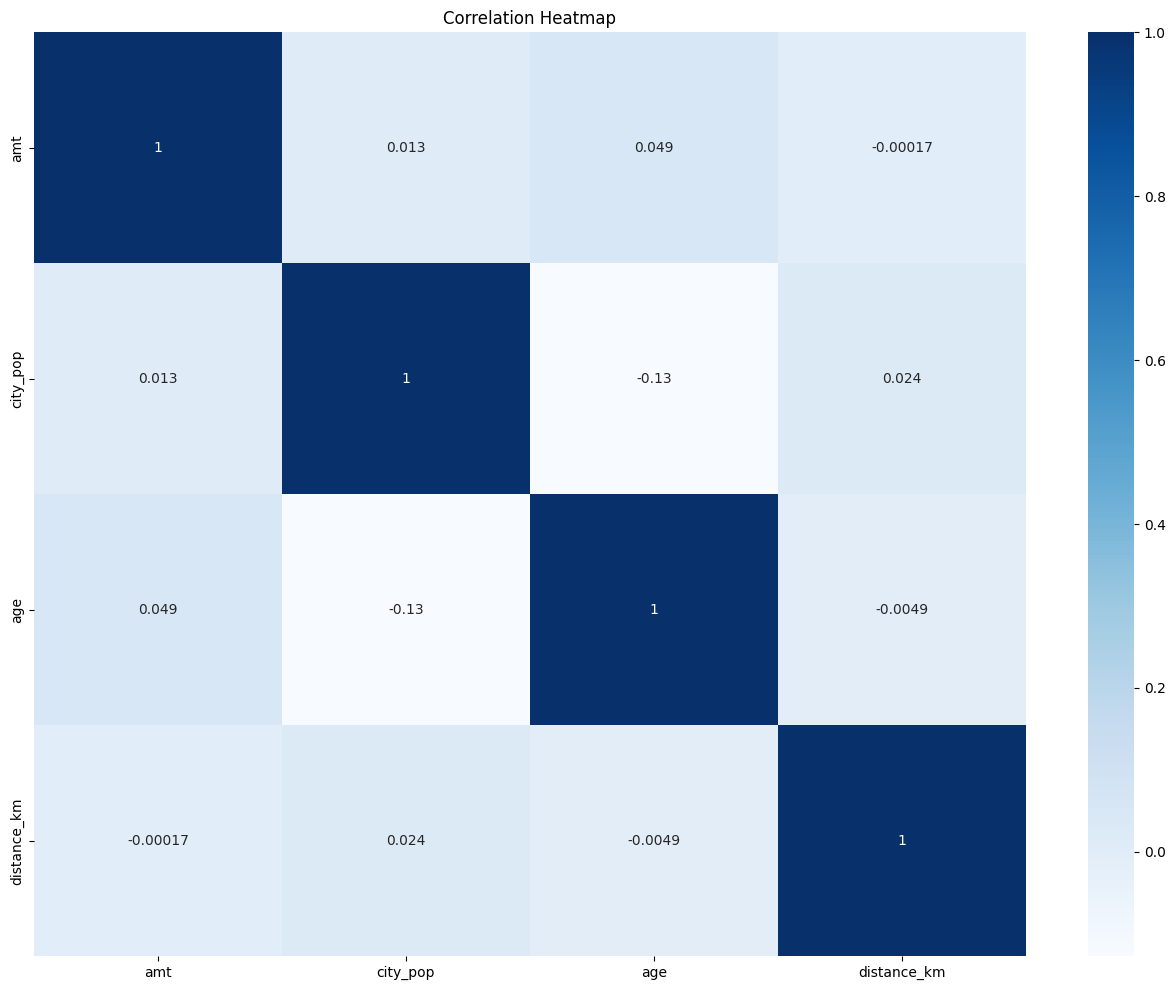

In [100]:
# The correlation matrix shows that the numeric data is not correlated.
quantdata = df[["amt", "city_pop", "age", "distance_km"]]
corr_matrix = quantdata.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title("Correlation Heatmap")
plt.show()

In [101]:
#No NAs in dataset before data modeling.
nan_counts = df.isna().sum()
print(nan_counts)

trans_date_trans_time    0
merchant                 0
category                 0
amt                      0
city                     0
state                    0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
merch_lat                0
merch_long               0
is_fraud                 0
age                      0
time_of_day              0
hour                     0
day_of_week              0
distance_km              0
dtype: int64


### Logistic Regression to Predict Fraud

In [102]:
#Split into Train and Test
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

In [103]:
formula = "is_fraud ~ age + amt + hour + category + state + distance_km"
log_reg = smf.logit(formula = formula, data = train_data).fit(maxiter=1000)

Optimization terminated successfully.
         Current function value: 0.161777
         Iterations 9


In [104]:
from IPython.display import display
#Predict Probabilities
preds = log_reg.predict(test_data)
#Add predictions and agreement columns to the dataframe
test_data['prob'] = preds
test_data['prediction'] = np.where(test_data['prob'] > 0.4, 1, 0)
test_data['agree'] = np.where(test_data['prediction'] == test_data['is_fraud'], 1, 0)
#calculate naive accuracy, model accuracy, and AUC
naive_accuracy = 1 - test_data['is_fraud'].sum() / len(test_data)
accuracy = test_data['agree'].sum() / len(test_data)
auc = roc_auc_score(test_data['is_fraud'], preds)
#Identify Disagreements
disagree = test_data[test_data['agree'] == 0]
#Display Results
display(naive_accuracy, accuracy, auc, log_reg.summary())

0.870327641901246

0.9499307798800185

0.9513992407060075

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_fraud   No. Observations:                10110
Model:                          Logit   Df Residuals:                    10058
Method:                           MLE   Df Model:                           51
Date:                Sun, 01 Dec 2024   Pseudo R-squ.:                  0.5746
Time:                        08:26:45   Log-Likelihood:                -1635.6
converged:                       True   LL-Null:                       -3844.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -3.1970      0.506     -6.314      0.000      -4.189      -2.205
hour[T.1]                     -0.0119      0.194     -0.062      0.951      -0.391       0.367
hour[T.2]                     -0.1448      0.203     -0.714      0.475      -0.542       0.253
hour[T.3]                     -0.1440      0.198     -0.728      0.467      -0.532       0.244
hour[T.4]                     -3.0260      0.528     -5.727      0.000      -4.062      -1.990
hour[T.5]                     -2.2039      0.376     -5.867      0.000      -2.940      -1.468
hour[T.6]                     -3.1428      0.601     -5.231      0.000      -4.320      -1.965
hour[T.7]                     -2.6172      0.447     -5.850      0.000      -3.494      -1.740
hour[T.8]                     -2.2148      0.377     -5.878      0.000      -2.953      -1.476
hour[T.9]                     -2.2080      0.401     -5.508      0.000      -2.994      -1.422
hour[T.10]                    -2.6311      0.458     -5.744      0.000      -3.529      -1.733
hour[T.11]                    -3.5404      0.642     -5.515      0.000      -4.799      -2.282
hour[T.12]                    -1.5983      0.475     -3.367      0.001      -2.529      -0.668
hour[T.13]                    -1.5013      0.473     -3.175      0.002      -2.428      -0.574
hour[T.14]                    -1.0161      0.416     -2.442      0.015      -1.832      -0.200
hour[T.15]                    -0.9721      0.402     -2.416      0.016      -1.761      -0.183
hour[T.16]                    -1.2807      0.432     -2.965      0.003      -2.127      -0.434
hour[T.17]                    -1.2383      0.418     -2.961      0.003      -2.058      -0.419
hour[T.18]                    -1.8301      0.460     -3.982      0.000      -2.731      -0.929
hour[T.19]                    -1.8026      0.532     -3.386      0.001      -2.846      -0.759
hour[T.20]                    -1.6120      0.468     -3.443      0.001      -2.529      -0.694
hour[T.21]                    -1.8780      0.466     -4.029      0.000      -2.792      -0.964
hour[T.22]                     1.6928      0.255      6.643      0.000       1.193       2.192
hour[T.23]                     1.8295      0.254      7.217      0.000       1.333       2.326
category[T.food_dining]        0.6458      0.327      1.974      0.048       0.005       1.287
category[T.gas_transport]      2.8235      0.323      8.750      0.000       2.191       3.456
category[T.grocery_net]        2.2260      0.394      5.650      0.000       1.454       2.998
category[T.grocery_pos]        2.5942      0.305      8.515      0.000       1.997       3.191
category[T.health_fitness]     0.7082      0.329      2.155      0.031       0.064       1.352
category[T.home]               0.3284      0.307      1.070      0.285      -0.273       0.930
category[T.kids_pets]          0.8922      0.305      2.928      0.003       0.295       1.489
category[T.

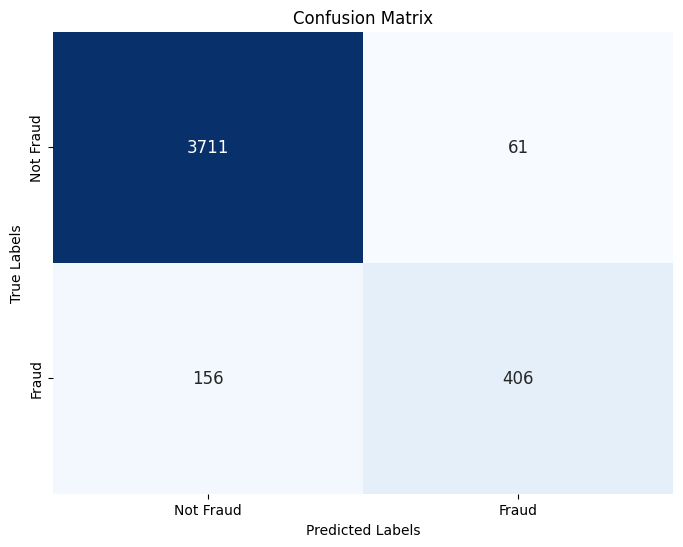

############################################################
                                                             Classification Report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3772
           1       0.87      0.72      0.79       562

    accuracy                           0.95      4334
   macro avg       0.91      0.85      0.88      4334
weighted avg       0.95      0.95      0.95      4334



In [105]:
# Compute the confusion matrix
cm = confusion_matrix(test_data['is_fraud'], test_data['prediction'])

# Define labels for the classes
labels = ["Not Fraud", "Fraud"]

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=labels, yticklabels=labels, annot_kws={"size": 12})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


print("#" * 60)
print(" " * 60, "Classification Report")
print(classification_report(test_data['is_fraud'], test_data['prediction']))

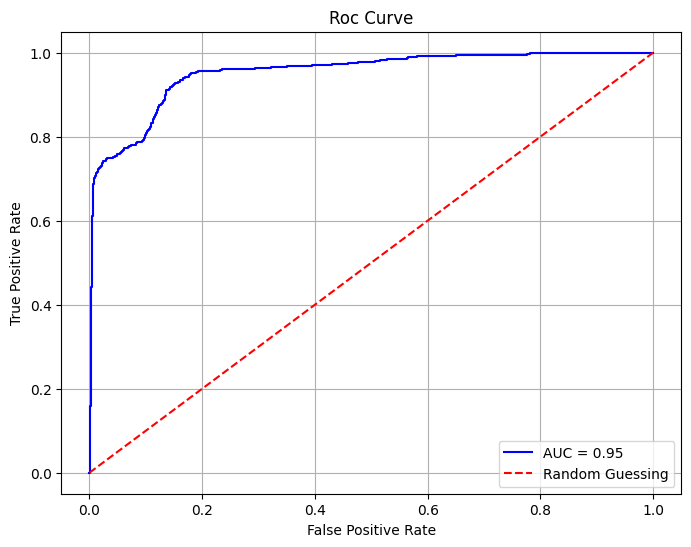

In [106]:
preds = log_reg.predict(test_data)
y_pred_proba = 1 / (1 + np.exp(-preds))

fpr, tpr, _ = roc_curve(test_data['is_fraud'], y_pred_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='b', label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Gradient Boosted Random Forest for Fraud Prediction

In [107]:
#creating a new dataframe for the Random Forest
dftree = df[['is_fraud', 'merchant', 'category', 'amt', 'city_pop', 'age', 'hour', 'day_of_week', 'distance_km']].copy()
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
le = LabelEncoder()

# Apply label encoding to each categorical column
dftree['merchant'] = le.fit_transform(dftree['merchant'])
dftree['category'] = le.fit_transform(dftree['category'])
dftree['day_of_week'] = le.fit_transform(dftree['day_of_week'])
dftree['hour'] = le.fit_transform(dftree['hour'])

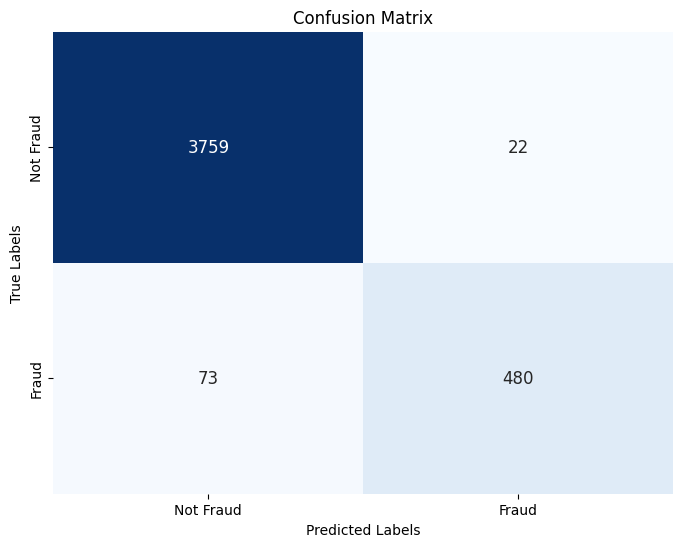

############################################################
                     Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3781
           1       0.96      0.87      0.91       553

    accuracy                           0.98      4334
   macro avg       0.97      0.93      0.95      4334
weighted avg       0.98      0.98      0.98      4334



In [108]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Splitting the dataset into train and test sets
X = dftree.drop(columns=['is_fraud'])  # Features
y = dftree['is_fraud']                # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize Random Forest with class weight to handle imbalanced classes
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]  # For AUC-ROC score


# Compute the confusion matrix
cm1 = confusion_matrix(y_test, y_pred)
# Define labels for the classes
labels = ["Not Fraud", "Fraud"]
plt.figure(figsize=(8,6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=labels, yticklabels=labels, annot_kws={"size": 12})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("#" * 60)
print(" " * 20, "Classification Report")
print(classification_report(y_test, y_pred))

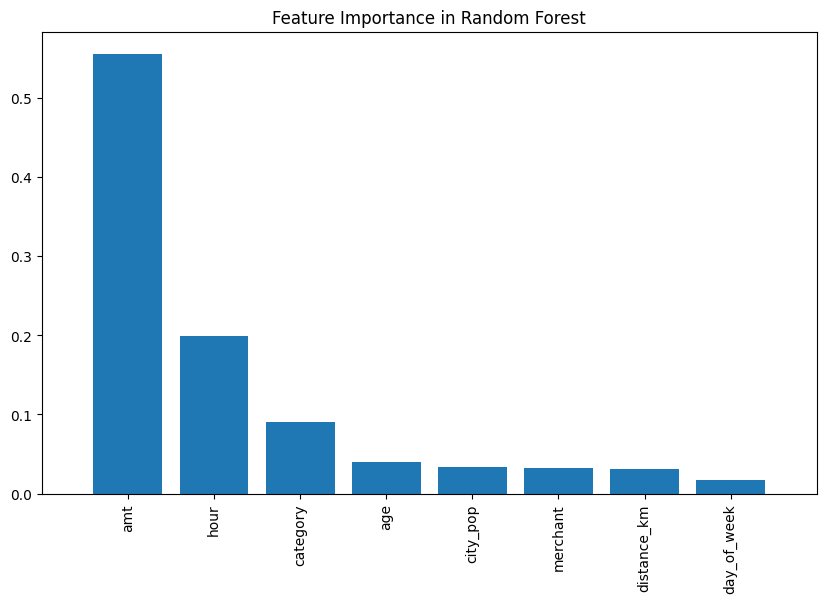

In [109]:
importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]

feature_names = X_train.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance in Random Forest")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), np.array(feature_names)[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [110]:
print(rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


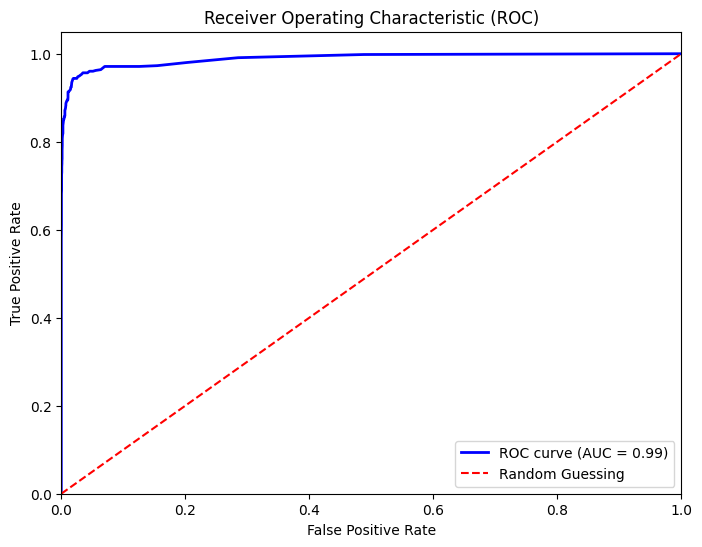

In [111]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [112]:
from sklearn.model_selection import cross_val_score
# Perform 5-fold cross-validation
scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')

# Print each fold's AUC score and the average
print("AUC scores for each fold:", scores)
print("Mean AUC score:", scores.mean())

AUC scores for each fold: [0.99086656 0.99029122 0.9936309  0.98812642 0.98812274]
Mean AUC score: 0.9902075685665845


#### Contributions

Cody:
- Found initial model
- Made edits to paramaters
- Made edits to features
- Tweaked logistic regression

Chase:
- Implemented random forest
- Edited forest as necessary

Pedro:
- Most of the mid-term report
- Most of the poster and printing